# Recovering order parameters with k-vectors
This notebook provides a general sketch of how one would go about recovering order parameters with k-vectors. To learn the k-vectors is more involved but theoretically possible but beyond the scope of this paper.

In [1]:
import torch
import torch_geometric as tg
import e3nn
from e3nn import rs, o3
from e3nn.networks import GatedConvParityNetwork
from e3nn.point.message_passing import Convolution
import e3nn.point.data_helpers as dh
from e3nn.tensor.spherical_tensor import SphericalTensor
import math
import numpy as np
import matplotlib.pyplot as plt

import pymatgen
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer

torch.set_default_dtype(torch.float64)

device = "cuda:3"

In [2]:
struct_221_primitive = Structure.from_file('structures/221_orig.cif')
struct_221 = Structure.from_file("structures/221_anon.cif")
struct_62 = Structure.from_file(filename="structures/62_anon_sorted.cif")

rlatt = torch.tensor(struct_221_primitive.lattice.reciprocal_lattice.abc)

# Rotate space group 62 setting lattice to match Cartesian coordinates of cubic setting
new_lattice = o3.rot_z(np.pi / 4.).T @ struct_221.lattice.matrix

struct_221 = Structure(new_lattice, struct_221.species, struct_221.frac_coords)
struct_62 = Structure(new_lattice, struct_62.species, struct_62.frac_coords)

print(struct_221.lattice)
lat = 4.055964

4.055964 4.055964 0.000000
-4.055964 4.055964 0.000000
0.000000 0.000000 8.112000


In [3]:
atom_types_list = ['A', 'B', 'X']
atom_indices = [atom_types_list.index(str(s.species)[0]) for s in struct_221]  # Remove decorators

### In this example, we simplify the order parameter recovery process a bit by stating which k-vectors we wish to recover order parameters for, in this case $M$ and $R$.

In [4]:
Rs_order_param = [(1, 1, 1)]  # Pseudovector
A_input = torch.tensor([1., 0., 0.]).unsqueeze(0)
B_input = torch.tensor([0., 1., 0.]).unsqueeze(0)
X_input = torch.tensor([0., 0., 1.]).unsqueeze(0)
atom_inputs = [A_input, B_input, X_input]
Rs_in = [(3, 0, 1)] + Rs_order_param # 3 atom types + order parameters
N = len(struct_221)
zeros = torch.zeros(N - 4, rs.dim(Rs_order_param))

R = torch.ones(3) * 0.5 # In L=1 basis
M1 = torch.tensor([1., 0., 1.]) * 0.5 # In L=1 basis, xy
kvecs = torch.stack([R, M1], dim=0)

pseudo_order_param_input = torch.zeros(kvecs.shape[0], 3) 
# pseudo_order_param_input[0] = torch.tensor([0.4, 0, 0.4])
pseudo_order_param_input.requires_grad = True

lmax = 6

Rs_out = [(1, 1, -1)]
r_max = 3.5

### This is the crucial part, we need to combine k-vector information with learnable order parameters.
Note, that we fix an origin for the distortion with our choice of centering `perm_normalized_B_coords`.

In [5]:
def create_features(
    kvecs,
    pseudo_order_param_input,
    normalized_B_coords):
    
    perm_normalized_B_coords = normalized_B_coords[:, [1, 2, 0]]
    
    vol = 1.
    order_param_input = torch.cos(2 * math.pi / vol * (kvecs.unsqueeze(0) * perm_normalized_B_coords.unsqueeze(1)).sum(-1)) # [r, k]
    order_param_input = order_param_input.unsqueeze(-1) * pseudo_order_param_input.unsqueeze(0) # [r, k, 3]
    order_param_input = order_param_input.sum(-2)  # sum over kvectors
    
    assert list(order_param_input.shape) == [4, 3]
    
    order_param = torch.cat([zeros, order_param_input], dim=0)

    N = len(atom_indices)
    all_atom_types = torch.cat([
        atom_inputs[i] for i in atom_indices
    ], dim=0)  # [N, atom_types]

    return torch.cat([all_atom_types, order_param], dim=-1)

### Same as before, define displacements, model, and optimizers.

In [6]:
relative_vecs_62 = []
for i, site in enumerate(struct_221):
    sites = struct_62.get_sites_in_sphere(site.coords, 1., include_index=True, include_image=True)
    sorted_sites = sorted(sites, key=lambda x: x[1])
    r = sorted_sites[0][0].coords - site.coords
    relative_vecs_62.append(r)
relative_vecs_62 = np.stack(relative_vecs_62, axis=0)
pos = torch.tensor(struct_221.cart_coords, dtype=torch.float64)
relative_vecs_62 = torch.tensor(relative_vecs_62, dtype=torch.float64)
print("max distortion in Angstroms (62): ", relative_vecs_62.norm(2, -1).max())

max distortion in Angstroms (62):  tensor(0.2565)


In [7]:
model_kwargs = {
    'convolution': Convolution,
    'Rs_in': Rs_in, 'Rs_out': Rs_out,
    'mul': 6, 'lmax': lmax, 'layers': 3,
    'max_radius': r_max,  # From dataset
    'number_of_basis': 10,
}

model = GatedConvParityNetwork(**model_kwargs)

In [8]:
opt = torch.optim.Adam(model.parameters(), 1e-3)
order_opt = torch.optim.Adam([pseudo_order_param_input], 1e-3)

In [9]:
model.load_state_dict(torch.load('spacegroup_62_model_overfit.torch')['model'])

<All keys matched successfully>

### Define our origin for the distortion.

In [10]:
normalized_B_coords = (torch.tensor(struct_62.cart_coords[-4:]) - torch.tensor(struct_62.cart_coords[-4:-3])) / lat
normalized_B_coords.requires_grad = True

### Train!

In [11]:
max_iter = 51

model.to(device)

for i in range(max_iter):
#     order_param_input.to('cpu')
    features = create_features(kvecs, 
                               pseudo_order_param_input, 
                               normalized_B_coords)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean()
    if i % 10 == 0:
        print("model update: ", loss)
    opt.zero_grad()
    loss.backward()
    opt.step() 
    
#     order_param_input.to('cpu')
    features = create_features(kvecs, 
                               pseudo_order_param_input, 
                               normalized_B_coords)
    data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
    data.to(device)
    output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)
    loss = ((output - data.y[:, [1, 2, 0]]).abs()).mean().cpu() 
    loss = loss + 1e-2 * pseudo_order_param_input.abs().mean()
    if i % 10 == 0:
        print("order param update: ", loss)
    order_opt.zero_grad()
    loss.backward()
    order_opt.step() 

model update:  tensor(0.0676, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0676, grad_fn=<AddBackward0>)
model update:  tensor(0.0581, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0563, grad_fn=<AddBackward0>)
model update:  tensor(0.0197, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0199, grad_fn=<AddBackward0>)
model update:  tensor(0.0130, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0123, grad_fn=<AddBackward0>)
model update:  tensor(0.0102, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0104, grad_fn=<AddBackward0>)
model update:  tensor(0.0106, device='cuda:3', grad_fn=<MeanBackward0>)
order param update:  tensor(0.0106, grad_fn=<AddBackward0>)


In [12]:
kvecs

tensor([[0.5000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000]])

In [13]:
rounded_pseudo = torch.tensor(pseudo_order_param_input.detach().numpy().round(3))

### Here we recover an order parameter analogous to $(a000bb)$ in the Howard 1998 notation.
where $(a00)$ cooresponds to a $z$ value for $M1$ and (0bb) coorespond to $-x$ and $+y$ values (minus sign comes from different in convention for $b$ vs. $a$ axis of 62 space group structure).

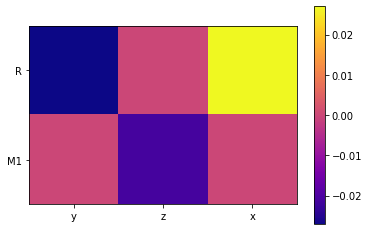

In [14]:
fig, ax = plt.subplots(1, 1)
mappable = ax.imshow(rounded_pseudo, cmap='plasma')
ax.set_yticks(range(len(kvecs)))
ax.set_yticklabels(["R", "M1", "M2", "M3"])
ax.set_xticks(range(3))
ax.set_xticklabels(['y', 'z', 'x'])
fig.colorbar(mappable)

In [15]:
rounded_pseudo

tensor([[-0.0270, -0.0000,  0.0270],
        [-0.0000, -0.0210,  0.0000]])

In [16]:
torch.save({'model': model.state_dict(), 
            'kvecs': kvecs,
            'pseudo_order_param_input': pseudo_order_param_input},
           'spacegroup_62_kvec_model_L_1(1).torch')

In [17]:
features = create_features(kvecs, 
                           rounded_pseudo, 
                           normalized_B_coords)
data = dh.DataPeriodicNeighbors(features, Rs_in, pos, struct_221.lattice.matrix, r_max, y=relative_vecs_62)
data.to(device)
output = model(data.x, data.edge_index, data.edge_attr, n_norm=6)

In [18]:
features[-4:, -3:]

tensor([[-0.0270, -0.0210,  0.0270],
        [ 0.0270,  0.0210, -0.0270],
        [-0.0270,  0.0210,  0.0270],
        [ 0.0270, -0.0210, -0.0270]], grad_fn=<SliceBackward>)

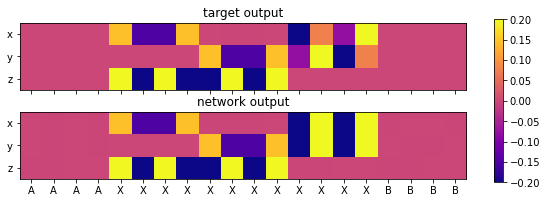

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 3))
bound = 0.2
mappable = ax[0].imshow(data.y.cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
ax[1].imshow(output[:, [2, 0, 1]].cpu().detach().numpy().T, cmap="plasma", vmax=bound, vmin=-bound)
sites = [str(s.species)[0] for s in struct_62]

ax[0].set_title('target output')
ax[1].set_title('network output')

ax[0].set_xticks(range(len(sites)))
ax[0].set_xticklabels([''] * len(sites))
ax[1].set_xticks(range(len(sites)))
ax[1].set_xticklabels(sites)

ax[0].set_yticks(range(3))
ax[1].set_yticks(range(3))
ax[0].set_yticklabels(['x', 'y', 'z'])
ax[1].set_yticklabels(['x', 'y', 'z'])
fig.colorbar(mappable, ax=ax)

In [20]:
new_struct = Structure(new_lattice, struct_221.species,
                       struct_221.cart_coords + output.cpu()[:, [2, 0, 1]].detach().numpy(),
                       coords_are_cartesian=True)
new_struct.to(filename='recovered_struct_kvec.cif')

In [21]:
pga = SpacegroupAnalyzer(new_struct, symprec=1e-3)
pga.get_space_group_number()

62